In [3]:
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd
import re

# set font size to all plots to 18
plt.rcParams.update({"font.size": 18})

In [ ]:
FILE = "../data/append_tik_tok_analysis_v2.xlsx"

df_tk = pd.read_excel(FILE)

df_tk = df_tk.drop_duplicates(subset="link")

df_tk["scrapped_comments"] = df_tk["comments_text"].apply(
    lambda x: len(str(x).split("|"))
)
total_comments = df_tk["scrapped_comments"].sum()
print(f"Total comments: {total_comments}")

In [ ]:
first_date = df_tk["date_parsed"].min()
last_date = df_tk["date_parsed"].max()

print(f"First date: {first_date} | Last date: {last_date}")

In [4]:
stop_words = set(stopwords.words("spanish"))
stop_words.add("-")
stop_words.add("|")

for w in [
    "hacer",
    "puede",
    "puedo",
    "quiero",
    "siempre",
    "así",
    "solo",
    "0993447612ambato",
    "0989471791portoviejo",
    "0993993296uio",
    "0991584023manta",
    "0997484509provincia",
    "0997478450provincia",
    "0968923496uio",
    "0993999296uio",
]:
    stop_words.add(w)

In [ ]:
# plot gauss distribution of dates
sns.histplot(df_tk["date_parsed"], kde=True)
plt.tight_layout()
plt.gcf().set_size_inches(12, 6)
plt.xlabel("Date")
plt.ylabel("Videos")
plt.xticks(rotation=90)
# rotate x labels
plt.savefig("../imgs/tik_tok_dates.png", dpi=300)

In [ ]:
df_tk["month-year"] = df_tk["date_parsed"].dt.to_period("M")
df_group_month = (
    df_tk.groupby("month-year").agg({"scrapped_comments": "sum"}).reset_index()
)
df_group_month = df_group_month[df_group_month["month-year"] != "2025-01"]

sns.barplot(
    x="month-year",
    y="scrapped_comments",
    data=df_group_month[df_group_month["month-year"] >= "2022-09"],
)
plt.xticks(rotation=90)
plt.tight_layout()
plt.gcf().set_size_inches(20, 10)
plt.xlabel("Month-Year")
plt.ylabel("Comments")
plt.savefig("../imgs/tik_tok_month_year.png", dpi=300)
"""
Rangos/Picos:
1: 2022-09 -> 2022-11
2: 2023-01 -> 2023-03
3: 2023-05 -> 2023-09
4: 2023-11 -> 2024-01
5: 2024-01 (Fito mi primo)
6: 2024-03 -> 2024-04
7: 2024-06 -> 2024-08
8: 2024-11 -> 2024-12
"""

In [167]:
from typing import List


def print_plot(
    _df, target_months: List[str], min_length_word: int = 4, num_bar: int = 60
):

    print(f"-" * 50)

    target_months = [pd.Period(month) for month in target_months]

    # create plt subplots, description on left and comments on right

    # fig, axs = plt.subplots(1, 2, figsize=(30, 8))

    for idx, target_columns in enumerate(["description", "comments_text"]):

        _df[target_columns] = _df[target_columns].apply(lambda x: str(x).lower())

        def _check_stop_words(words: str) -> bool:
            word_list = words.split()

            words_allowed = []

            for word in word_list:
                word = re.sub(r"[^\w\s]", "", word).strip().lower()
                if word == "tc":
                    words_allowed.append(word)
                if (
                    word not in stop_words
                    and len(word) > min_length_word
                    and not word.startswith("@")
                ):
                    words_allowed.append(word)

            return " ".join(words_allowed)

        _df[target_columns] = _df[target_columns].apply(lambda x: _check_stop_words(x))

        _df["month-year"] = _df["date_parsed"].dt.to_period("M")

        target = _df[_df["month-year"].isin(target_months)]
        print(f"Total rows: {len(target)}")

        df_group_comments = (
            _df.groupby("month-year").agg({target_columns: " ".join}).reset_index()
        )

        words = df_group_comments[df_group_comments["month-year"].isin(target_months)][
            target_columns
        ]

        words_rows = []

        for row in words:
            words_rows.extend(row.split())

        print(f"Total words: {len(words_rows)}")

        dict_words = {}

        for word in words_rows:

            word = re.sub(r"[^\w\s]", "", word).strip()

            if word not in dict_words:

                dict_words[word] = 1

            else:

                dict_words[word] += 1

        print(
            f"Words of {len(dict_words)}",
            "0993993296uio" in dict_words.keys(),
            dict_words.keys(),
        )

        df_words = pd.DataFrame(dict_words.items(), columns=["word", "count"])

        df_words = df_words.sort_values(by="count", ascending=False)

        df_words = df_words.head(num_bar)

        fig = sns.barplot(data=df_words, x="word", y="count")

        plt.gcf().set_size_inches(16, 5)

        plt.xlabel("Word")
        plt.title(
            "Description of Tik Tok"
            if target_columns == "description"
            else "Comments of Tik Tok"
        )
        #  set x label to Word

        # tight layout
        plt.tight_layout()

        #  plt.xticks(rotation=90)
        fig.set_xticklabels(fig.get_xticklabels(), rotation=90)

        fig.set(ylabel="Count")

        print(f"Plotting {target_columns} of {target_months}")

        # wordcloud = WordCloud(
        #     width=800, height=400, background_color="white"
        # ).generate_from_frequencies(dict_words)

        # plt.figure(figsize=(12, 6))

        # plt.imshow(wordcloud, interpolation="bilinear")

        # plt.axis("off")

        # print(f"Wordcloud of {target_columns} of {target_months}")
        plt.savefig(f"../imgs/tik_tok_{target_columns}_{target_months}.png", dpi=300)

        plt.show()

    # plt.show()

In [ ]:
min_length_word = 4
num_bar = 20
"""
Rangos/Picos:
1: 2022-09 -> 2022-11
2: 2023-01 -> 2023-03
3: 2023-05 -> 2023-09
4: 2023-11 -> 2024-01
5: 2024-01 (Fito mi primo)
6: 2024-03 -> 2024-04
7: 2024-06 -> 2024-08
8: 2024-11 -> 2024-12
"""
print_plot(df_tk, ["2022-09", "2022-10", "2022-11"], min_length_word, num_bar)
# print_plot(df_tk, ["2023-01", "2023-02", "2023-03"], min_length_word, num_bar)
# print_plot(df_tk, ["2023-05", "2023-06", "2023-07"], min_length_word, num_bar)
# print_plot(df_tk, ["2023-07", "2023-08", "2023-09"], min_length_word, num_bar)
# print_plot(df_tk, ["2023-11", "2023-12"], min_length_word, num_bar)
print_plot(df_tk, ["2024-01"], min_length_word, num_bar)
print_plot(df_tk, ["2024-03", "2024-04"], min_length_word, num_bar)
print_plot(df_tk, ["2024-06", "2024-07", "2024-08"], min_length_word, num_bar)
print_plot(df_tk, ["2024-11", "2024-12"], min_length_word, num_bar)

In [ ]:
df = df_tk

In [ ]:
# Set display options to show all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

# Simply print the first few rows of the dataframe
print(df.head().to_string())

In [ ]:
# Split the comments_text by "|" and explode the list into separate rows
df_exploded = df.assign(comment=df["comments_text"].str.split("|")).explode("comment")

# Drop the original comments_text column as it's no longer needed
df_exploded = df_exploded.drop(columns=["comments_text"])

# Reset the index for the new DataFrame
df_exploded = df_exploded.reset_index(drop=True)

print(df_exploded.head().to_string())

In [ ]:
from pysentimiento.preprocessing import preprocess_tweet

# Apply preprocessing to both 'comment' and 'description' columns in df_exploded
df_exploded['processed_comment'] = df_exploded['comment'].apply(lambda x: preprocess_tweet(
    str(x),
    shorten=2,  # Shorten repeated characters
    lang="es",  # Spanish language
))

df_exploded['processed_description'] = df_exploded['description'].apply(lambda x: preprocess_tweet(
    str(x),
    shorten=2,  # Shorten repeated characters
    lang="es",  # Spanish language
))

# Print a few examples of original vs processed text
print("Original vs Processed Text:")
pd.set_option('display.max_colwidth', None)
print(df_exploded[['comment', 'processed_comment', 'description', 'processed_description']].head().to_string())

In [ ]:
# Create figure with two rows for wordcloud and histogram
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# Process description text
description_text = ' '.join(df_exploded['processed_description'].astype(str))
comment_text = ' '.join(df_exploded['processed_comment'].astype(str))

# Create word frequency dictionaries
desc_words = {}
comment_words = {}

# Count words for description
for word in description_text.split():
    if word not in stop_words and len(word) > min_length_word:
        desc_words[word] = desc_words.get(word, 0) + 1

# Count words for comments
for word in comment_text.split():
    if word not in stop_words and len(word) > min_length_word:
        comment_words[word] = comment_words.get(word, 0) + 1

# Generate wordclouds
desc_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(desc_words)
comment_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(comment_words)

# Plot wordclouds
ax1.imshow(desc_wordcloud, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Description Wordcloud')

ax2.imshow(comment_wordcloud, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Comments Wordcloud')

# Create DataFrames for plotting histograms
desc_df = pd.DataFrame(list(desc_words.items()), columns=['word', 'count'])
comment_df = pd.DataFrame(list(comment_words.items()), columns=['word', 'count'])

# Sort by count and get top words
desc_df = desc_df.sort_values('count', ascending=False).head(num_bar)
comment_df = comment_df.sort_values('count', ascending=False).head(num_bar)

# Plot histograms
sns.barplot(data=desc_df, x='word', y='count', ax=ax3)
ax3.tick_params(axis='x', rotation=90)
ax3.set_title('Top Words in Descriptions')

sns.barplot(data=comment_df, x='word', y='count', ax=ax4)
ax4.tick_params(axis='x', rotation=90)
ax4.set_title('Top Words in Comments')

plt.tight_layout()
plt.show()

In [ ]:
# Create lists for sectors and genres
sectors = ['norte', 'sur', 'centro']
genres = ['hombre', 'mujer']  # We'll handle plural forms in the counting logic

# Create dictionaries for counts
sector_desc = {sector: 0 for sector in sectors}
sector_comm = {sector: 0 for sector in sectors}
genre_desc = {genre: 0 for genre in genres}
genre_comm = {genre: 0 for genre in genres}

# Count mentions in descriptions and comments
for sector in sectors:
    sector_desc[sector] = df_exploded[df_exploded['processed_description'].str.contains(sector, case=False, na=False)].shape[0]
    sector_comm[sector] = df_exploded[df_exploded['processed_comment'].str.contains(sector, case=False, na=False)].shape[0]

# Count mentions for genres (including plural forms)
genre_desc['mujer'] = df_exploded[df_exploded['processed_description'].str.contains('mujer|mujeres', case=False, na=False, regex=True)].shape[0]
genre_desc['hombre'] = df_exploded[df_exploded['processed_description'].str.contains('hombre|hombres', case=False, na=False, regex=True)].shape[0]
genre_comm['mujer'] = df_exploded[df_exploded['processed_comment'].str.contains('mujer|mujeres', case=False, na=False, regex=True)].shape[0]
genre_comm['hombre'] = df_exploded[df_exploded['processed_comment'].str.contains('hombre|hombres', case=False, na=False, regex=True)].shape[0]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot sectors
x = range(len(sectors))
width = 0.35

# Create bars with different colors and hatching patterns
bars1 = ax1.bar([i - width/2 for i in x], [sector_desc[sector] for sector in sectors], width, 
                label='Descriptions', color='skyblue', edgecolor='black', hatch='x')
bars2 = ax1.bar([i + width/2 for i in x], [sector_comm[sector] for sector in sectors], width, 
                label='Comments', color='lightcoral', edgecolor='black', hatch='o')

ax1.set_ylabel('Count')
ax1.set_title('Mentions by Sector')
ax1.set_xticks(x)
ax1.set_xticklabels(sectors)
ax1.legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

# Plot genres with different colors and hatching patterns
x = range(len(genres))
bars3 = ax2.bar([i - width/2 for i in x], [genre_desc[genre] for genre in genres], width, 
                label='Descriptions', color='skyblue', edgecolor='black', hatch='x')
bars4 = ax2.bar([i + width/2 for i in x], [genre_comm[genre] for genre in genres], width, 
                label='Comments', color='lightcoral', edgecolor='black', hatch='o')

ax2.set_ylabel('Count')
ax2.set_title('Mentions by Genre')
ax2.set_xticks(x)
ax2.set_xticklabels(genres)
ax2.legend()

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [24]:
# exclusive
peak_words = [
    ["policía", "policías"],  # OR
    ["militares"],  # OR
    ["delincuentes", "antisociales", "criminales"],  # OR
    "detenidos",
    "banda",
    ["presidente", "noboa", "daniel", "fénix", "gobierno"],  # OR
    "sicarios",
    "jueces",
    "correa",
    "asambleístas",
]

Total comments: 26244
--------------------------------------------------
['2022-09', '2022-10', '2022-11']
Total Tik Tok opinions: 833
Total Twitter opinions: 3


C:\Users\emman\AppData\Local\Temp\ipykernel_27436\1500376865.py:353: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_entities.index, rotation=0, ha="right")


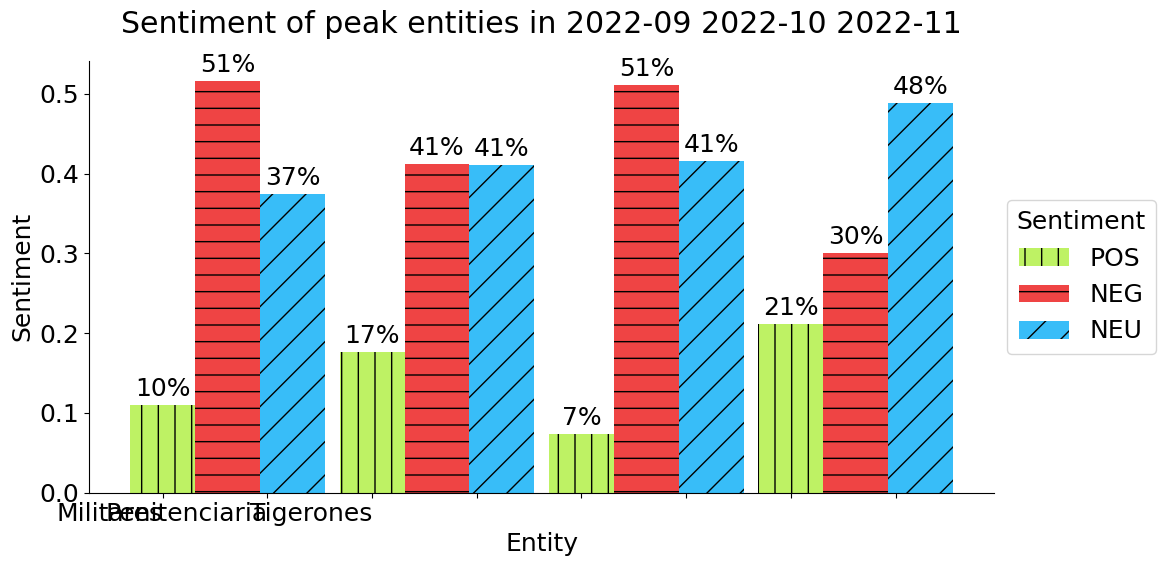

--------------------------------------------------
--------------------------------------------------
['2024-01']
Total Tik Tok opinions: 1766
Total Twitter opinions: 105


C:\Users\emman\AppData\Local\Temp\ipykernel_27436\1500376865.py:353: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_entities.index, rotation=0, ha="right")


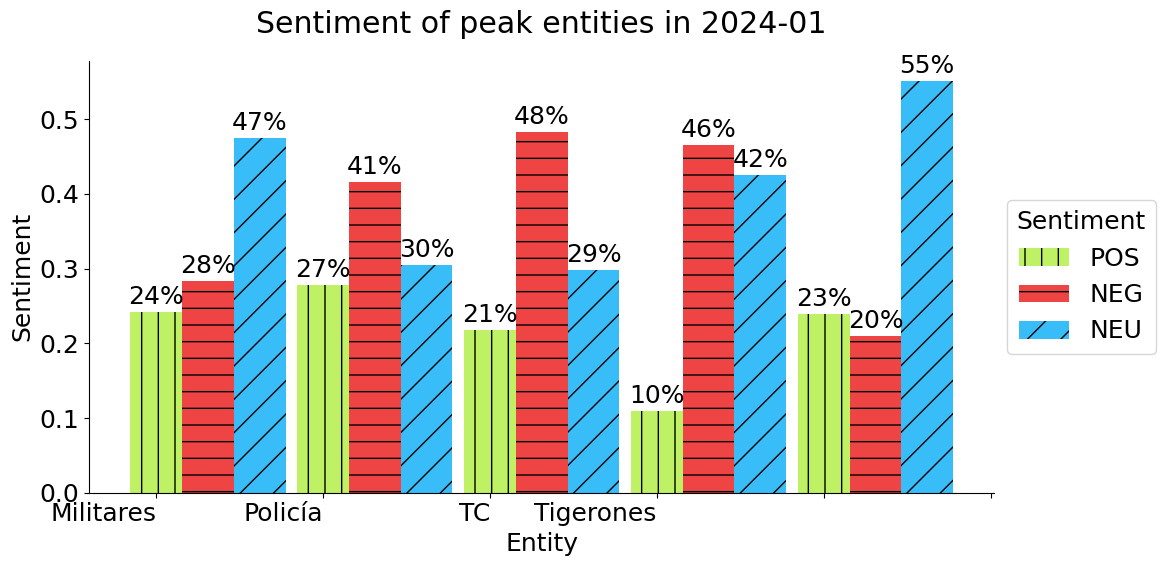

--------------------------------------------------
--------------------------------------------------
['2024-03', '2024-04']
Total Tik Tok opinions: 968
Total Twitter opinions: 6


C:\Users\emman\AppData\Local\Temp\ipykernel_27436\1500376865.py:353: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_entities.index, rotation=0, ha="right")


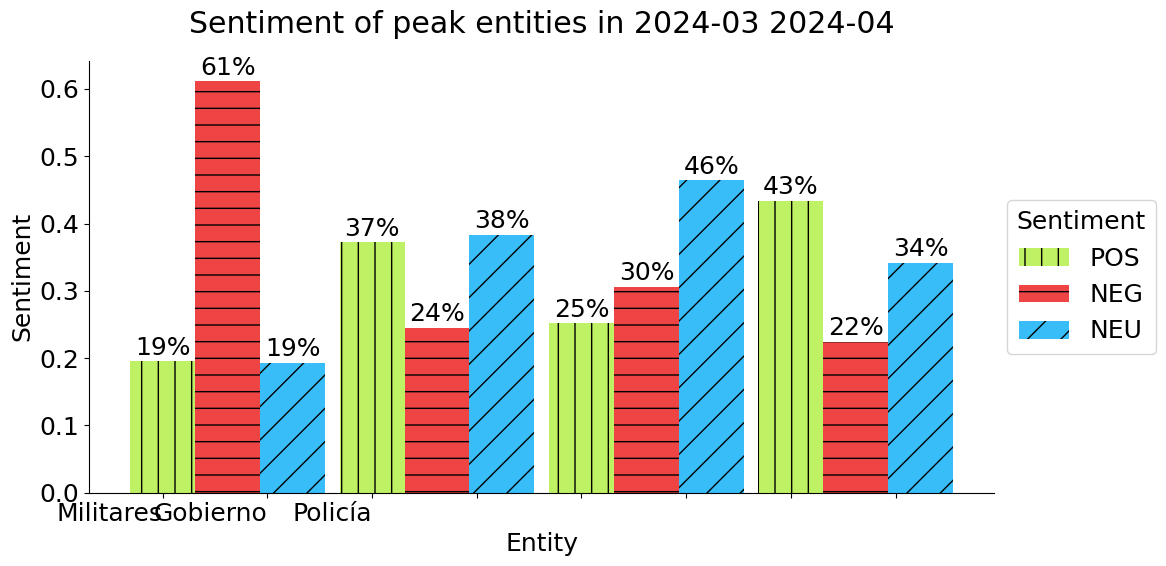

--------------------------------------------------
--------------------------------------------------
['2024-06', '2024-07', '2024-08']
Total Tik Tok opinions: 2598
Total Twitter opinions: 87


C:\Users\emman\AppData\Local\Temp\ipykernel_27436\1500376865.py:353: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_entities.index, rotation=0, ha="right")


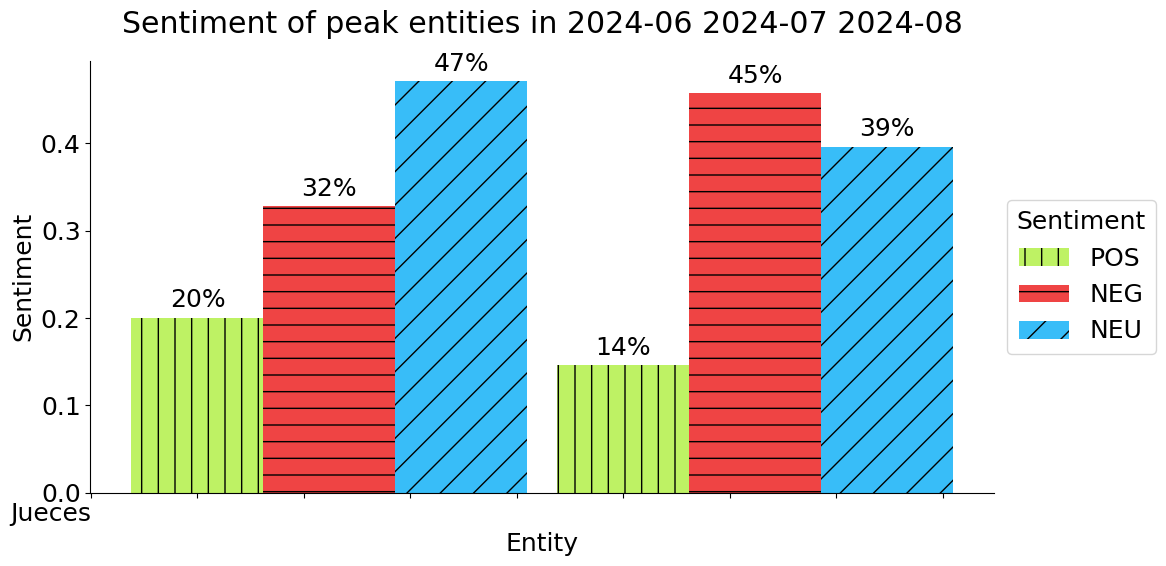

--------------------------------------------------
--------------------------------------------------
['2024-11', '2024-12']
Total Tik Tok opinions: 2522
Total Twitter opinions: 136


C:\Users\emman\AppData\Local\Temp\ipykernel_27436\1500376865.py:353: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_entities.index, rotation=0, ha="right")


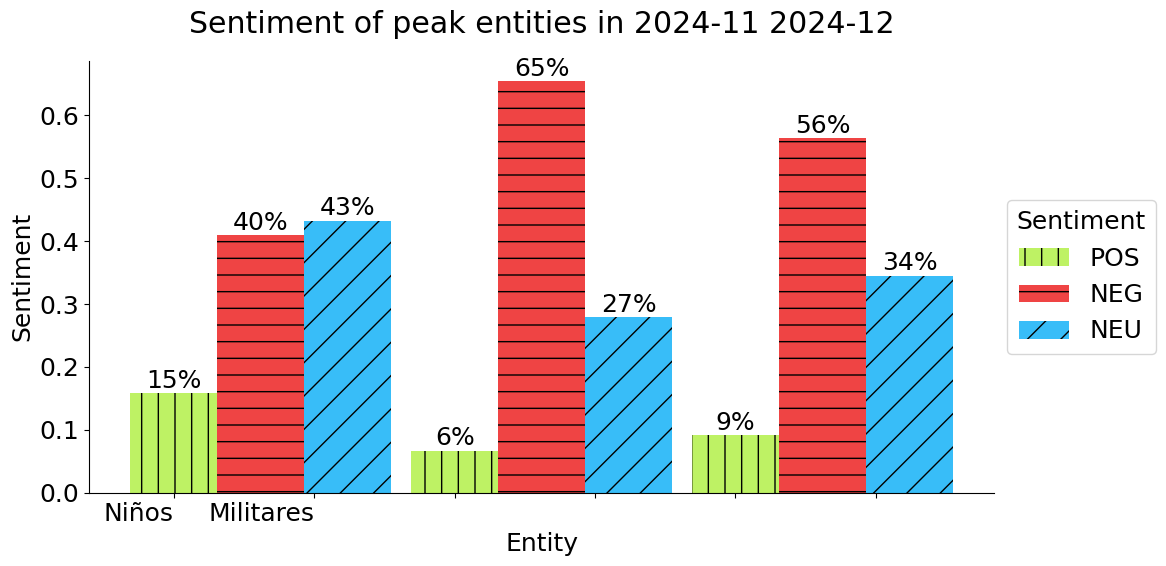

--------------------------------------------------


In [ ]:
from typing import List

super_map = [
    {
        "range": ["2022-09", "2022-10", "2022-11"],
        "peak_words": [
            {
                "entity": "Penitenciaria",
                "related": [
                    "cárcel",
                    "penitenciaria",
                    "balacera",
                    "penitenciaría",
                    "cárceles",
                    "pabellón",
                    "balaceras",
                    "balacera",
                ],
            },
            {
                "entity": "Gobierno",
                "related": ["presidente", "lasso", "gobierno"],
            },
            {
                "entity": "Tigerones",
                "related": ["rulay", "andamos", "tigerón", "tigerones"],
            },
            {
                "entity": "Militares",
                "related": ["militares", "militar", "ejército"],
            },
        ],
    },
    {
        "range": ["2024-01"],
        "peak_words": [
            {
                "entity": "TC",
                "related": [
                    "canal",
                    "televisión",
                    "tc",
                    "tctelevision",
                    "ingresaron",
                    "delincuentes",
                    "enero",
                ],
            },
            {
                "entity": "Tigerones",
                "related": ["rulay", "andamos", "tigerón", "tigerones"],
            },
            {
                "entity": "Gobierno",
                "related": [
                    "presidente",
                    "noboa",
                    "gobierno",
                    "daniel",
                    "fénix",
                    "plan",
                ],
            },
            {
                "entity": "Policía",
                "related": ["policía", "policías"],
            },
            {
                "entity": "Militares",
                "related": ["militares", "militar", "ejército"],
            },
        ],
    },
    {
        "range": ["2024-03", "2024-04"],
        "peak_words": [
            {
                "entity": "Penitenciaria",
                "related": [
                    "regional",
                    "cárcel",
                    "penitenciaria",
                    "balacera",
                    "penitenciaría",
                    "cárceles",
                    "pabellón",
                    "balaceras",
                    "balacera",
                ],
            },
            {
                "entity": "Militares",
                "related": ["militares", "militar", "ejército"],
            },
            {
                "entity": "Policía",
                "related": ["policía", "policías"],
            },
            {
                "entity": "Gobierno",
                "related": [
                    "presidente",
                    "noboa",
                    "gobierno",
                    "daniel",
                    "fénix",
                    "plan",
                ],
            },
        ],
    },
    {
        "range": ["2024-06", "2024-07", "2024-08"],
        "peak_words": [
            {
                "entity": "Jueces",
                "related": [
                    "juez",
                    "jueces",
                    "corruptos",
                    "fiscales",
                    "fiscal",
                    "libres",
                    "leyes",
                ],
            },
            {
                "entity": "Gobierno",
                "related": [
                    "presidente",
                    "noboa",
                    "gobierno",
                    "daniel",
                    "fénix",
                    "plan",
                ],
            },
        ],
    },
    {
        "range": ["2024-11", "2024-12"],
        "peak_words": [
            {
                "entity": "Niños",
                "related": [
                    "niños",
                    "niño",
                    "menor",
                    "menores",
                    "malvinas",
                    "padres",
                    # "justicia",
                ],
            },
            {
                "entity": "Gobierno",
                "related": [
                    "presidente",
                    "noboa",
                    "gobierno",
                    "daniel",
                    "fénix",
                    "plan",
                ],
            },
            {
                "entity": "Militares",
                "related": ["militares", "militar", "ejército"],
            },
        ],
    },
]


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# set font size to all plots to 18
plt.rcParams.update({"font.size": 18})

df_tk = pd.read_excel("../data/append_tik_tok_analysis_v4_context.xlsx")
df_tk = df_tk.drop_duplicates(subset="link")
df_tk["scrapped_comments"] = df_tk["comments_text"].apply(
    lambda x: len(str(x).split("|"))
)
df_tk["month-year"] = df_tk["date_parsed"].dt.to_period("M")
total_comments = df_tk["scrapped_comments"].sum()
print(f"Total comments: {total_comments}")

df_x = pd.read_excel("../data/append_tweets_analysis_v4_context.xlsx")
df_x["date_parsed"] = pd.to_datetime(df_x["date_parsed"])
df_x["month-year"] = df_x["date_parsed"].dt.to_period("M")


def calculate_sentiments(
    _df_tiktok: pd.DataFrame, _df_x: pd.DataFrame, _super_map: List[dict]
) -> pd.DataFrame:
    def _min_text(text: str) -> str:
        if text != "nan" and len(text) > 4:
            return True

        return False

    for super_map in _super_map:

        print(f"-" * 50)

        print(super_map["range"])

        _df_filtered = _df_tiktok[
            _df_tiktok["month-year"].isin(pd.Period(x) for x in super_map["range"])
        ]

        opinions = []

        tk_opinions = 0

        for _, row in _df_filtered.iterrows():
            analysis = eval(row["analysis"])

            description_analysis = analysis["description"]

            if (
                _min_text(description_analysis["text"])
                and description_analysis["analysis"]
            ):
                opinions.append(
                    {
                        "text": description_analysis["text"],
                        "probas": description_analysis["analysis"]["probas"],
                    }
                )
                tk_opinions += 1

            for comment in analysis["comments"]:
                if _min_text(comment["text"]) and comment["analysis"]:
                    opinions.append(
                        {
                            "text": comment["text"],
                            "probas": comment["analysis"]["probas"],
                        }
                    )
                    tk_opinions += 1

        print(f"Total Tik Tok opinions: {tk_opinions}")

        x_opinions = 0

        _df_x_filtered = _df_x[
            _df_x["month-year"].isin(pd.Period(x) for x in super_map["range"])
        ]

        for _, row in _df_x_filtered.iterrows():
            analysis = eval(row["analysis"])

            text = analysis["text"]
            analysis = analysis["analysis"]

            if _min_text(text) and analysis:
                opinions.append(
                    {
                        "text": text,
                        "probas": analysis["probas"],
                    }
                )
                x_opinions += 1

        print(f"Total Twitter opinions: {x_opinions}")

        entities_dict = {}

        for opinion in opinions:
            text = opinion["text"]
            probas = opinion["probas"]

            for peak_word in super_map["peak_words"]:
                entity = peak_word["entity"]
                related = peak_word["related"]

                for word in related:
                    if word.lower() in text.lower():
                        if entity not in entities_dict:
                            entities_dict[entity] = {
                                "count": 1,
                                "probas": probas,
                            }
                        else:
                            entities_dict[entity]["count"] += 1
                            for key in probas.keys():
                                entities_dict[entity]["probas"][key] += probas[key]

        entities_mean = []

        for entity, data in entities_dict.items():
            mean_probas = {
                key: data["probas"][key] / data["count"]
                for key in data["probas"].keys()
            }

            entities_mean.append(
                {
                    "entity": entity,
                    "pos": mean_probas["POS"],
                    "neg": mean_probas["NEG"],
                    "neu": mean_probas["NEU"],
                }
            )

        # plot a stacked bar chart with the sentiment of each entity and inside of each stack shwo the percentage of each sentiment
        df_entities = pd.DataFrame(entities_mean)

        df_entities = df_entities.set_index("entity")

        # Definir colores y texturas
        colors = {"pos": "#bef264", "neg": "#ef4444", "neu": "#38bdf8"}
        hatches = {"pos": "|", "neg": "-", "neu": "/"}

        # Crear el gráfico de barras agrupadas
        _, ax = plt.subplots(figsize=(16, 8))
        bar_width = 0.31
        index = pd.Index(range(len(df_entities)))
        for i, sentiment in enumerate(["pos", "neg", "neu"]):
            ax.bar(
                index + i * bar_width,
                df_entities[sentiment],
                color=colors[sentiment],
                hatch=hatches[sentiment],
                width=bar_width,
                label=sentiment.upper(),
            )

        # Añadir los valores dentro de las barras
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy()
            if height > 0:
                ax.text(
                    x + width / 2,
                    y + height + 0.02,
                    f"{int(height * 100)}%",
                    ha="center",
                    va="center",
                )

        plt.gcf().set_size_inches(12, 6)

        # Eliminar los bordes superior y derecho
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        ax.set_xticks(index + bar_width + bar_width)
        ax.set_xticklabels(df_entities.index, rotation=0, ha="right")

        text = " ".join(super_map["range"])
        plt.xlabel("Entity")
        plt.ylabel("Sentiment")
        plt.title(f"Sentiment of peak entities in {text}", pad=20)
        plt.legend(title="Sentiment", loc="center left", bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.savefig(f"../imgs/tik_tok_sentiment_{text}_V2.png", dpi=300)
        plt.show()
        print(f"-" * 50)


calculate_sentiments(df_tk, df_x, super_map)

In [ ]:
def contains_peak_words(text, peak_words):
    matches = []
    if pd.isna(text) or text == "":
        return matches

    for i, group in enumerate(peak_words):
        if isinstance(group, list):
            if any(word.lower() in text.lower() for word in group):
                matches.append(i)
        else:
            if group.lower() in text.lower():
                matches.append(i)
    return matches if matches else []


# Analyze description and comments separately
df_exploded["description_matches"] = df_exploded["description"].apply(
    lambda x: contains_peak_words(str(x), peak_words)
)
df_exploded["comment_matches"] = df_exploded["processed_comment"].apply(
    lambda x: contains_peak_words(str(x), peak_words)
)

# Create boolean columns for each group in descriptions
for group_id, group_name in peak_word_groups.items():
    df_exploded[f"desc_{group_name}"] = df_exploded["description_matches"].apply(
        lambda x: group_id in x
    )
    df_exploded[f"comment_{group_name}"] = df_exploded["comment_matches"].apply(
        lambda x: group_id in x
    )

# Calculate stats for descriptions and comments separately
desc_stats = {}
comment_stats = {}

for group_id, group_name in peak_word_groups.items():
    desc_count = df_exploded[f"desc_{group_name}"].sum()
    comment_count = df_exploded[f"comment_{group_name}"].sum()
    desc_stats[group_name] = desc_count
    comment_stats[group_name] = comment_count

# Print summary
print("\nDescription Peak Word Statistics:")
for group_name, count in desc_stats.items():
    print(f"{group_name}: {count} matches")

print("\nComment Peak Word Statistics:")
for group_name, count in comment_stats.items():
    print(f"{group_name}: {count} matches")

# Calculate overlap between description and comments
overlap_stats = {}
for group_name in peak_word_groups.values():
    overlap = df_exploded[
        df_exploded[f"desc_{group_name}"] & df_exploded[f"comment_{group_name}"]
    ].shape[0]
    overlap_stats[group_name] = overlap

print("\nOverlap Statistics (words appearing in both description and comments):")
for group_name, count in overlap_stats.items():
    print(f"{group_name}: {count} overlaps")

In [ ]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Sort the data by count for better visualization
desc_items = sorted(desc_stats.items(), key=lambda x: x[1], reverse=True)
comment_items = sorted(comment_stats.items(), key=lambda x: x[1], reverse=True)

# Plot description statistics
desc_words = [item[0] for item in desc_items]
desc_counts = [item[1] for item in desc_items]
bars1 = ax1.bar(desc_words, desc_counts)
ax1.set_title("Peak Words in Descriptions")
ax1.set_ylabel("Count")
ax1.tick_params(axis="x", rotation=45)

# Plot comment statistics
comment_words = [item[0] for item in comment_items]
comment_counts = [item[1] for item in comment_items]
bars2 = ax2.bar(comment_words, comment_counts)
ax2.set_title("Peak Words in Comments")
ax2.set_ylabel("Count")
ax2.tick_params(axis="x", rotation=45)


# Add value labels on top of each bar
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{int(height):,}",
            ha="center",
            va="bottom",
        )


add_value_labels(ax1, bars1)
add_value_labels(ax2, bars2)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [ ]:
import time
import pandas as pd
import torch
from pysentimiento import create_analyzer

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create a hate speech analyzer for Spanish language
hate_speech_analyzer = create_analyzer(task="hate_speech", lang="es", device=device)


# Function to analyze hate speech in text
def analyze_hate_speech(text):
    if pd.isna(text) or text == "":
        return {"output": [], "hateful": None, "targeted": None, "aggressive": None}
    result = hate_speech_analyzer.predict(text)
    return {
        "output": result.output,
        "hateful": result.probas["hateful"],
        "targeted": result.probas["targeted"],
        "aggressive": result.probas["aggressive"],
    }


# Function to process a batch of data
def process_batch(df_batch):
    df_batch["description_hate_speech"] = df_batch.apply(
        lambda row: (
            row["description_hate_speech"]
            if isinstance(row["description_hate_speech"], dict)
            and row["description_hate_speech"]["output"]
            else analyze_hate_speech(str(row["description"]))
        ),
        axis=1,
    )
    df_batch["comment_hate_speech"] = df_batch.apply(
        lambda row: (
            row["comment_hate_speech"]
            if isinstance(row["comment_hate_speech"], dict)
            and row["comment_hate_speech"]["output"]
            else analyze_hate_speech(str(row["processed_comment"]))
        ),
        axis=1,
    )
    return df_batch


# Filter the dataset to include only rows with matches
df_matches = df_exploded[
    (
        df_exploded["description"].apply(
            lambda x: any(
                word in str(x).lower()
                for group in peak_words
                for word in (group if isinstance(group, list) else [group])
            )
        )
    )
    | (
        df_exploded["processed_comment"].apply(
            lambda x: any(
                word in str(x).lower()
                for group in peak_words
                for word in (group if isinstance(group, list) else [group])
            )
        )
    )
]

# Initialize columns if they don't exist
if "description_hate_speech" not in df_exploded.columns:
    df_exploded["description_hate_speech"] = None
if "comment_hate_speech" not in df_exploded.columns:
    df_exploded["comment_hate_speech"] = None

# Split the filtered dataset into batches
batch_size = 100  # Adjust the batch size as needed
num_batches = len(df_matches) // batch_size + 1

# Process each batch and measure the time taken
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df_matches))
    df_batch = df_matches.iloc[start_idx:end_idx]

    start_time = time.time()
    df_batch = process_batch(df_batch)
    end_time = time.time()

    elapsed_time = end_time - start_time
    print(f"Time taken for batch {i + 1}/{num_batches}: {elapsed_time:.2f} seconds")

    # Calculate the number and proportion of records with non-empty output
    description_with_output = (
        df_batch["description_hate_speech"].apply(lambda x: bool(x["output"])).sum()
    )
    comment_with_output = (
        df_batch["comment_hate_speech"].apply(lambda x: bool(x["output"])).sum()
    )
    total_records = len(df_batch)
    total_with_output = description_with_output + comment_with_output
    proportion_with_output = total_with_output / (2 * total_records)
    print(
        f"Batch {i + 1}: {total_with_output} records with non-empty output, proportion: {proportion_with_output:.2f}"
    )

    # Calculate the number of unique descriptions and comments with non-empty output
    unique_descriptions_with_output = df_batch[
        df_batch["description_hate_speech"].apply(lambda x: bool(x["output"]))
    ]["description"].nunique()
    unique_comments_with_output = df_batch[
        df_batch["comment_hate_speech"].apply(lambda x: bool(x["output"]))
    ]["processed_comment"].nunique()
    print(
        f"Batch {i + 1}: {unique_descriptions_with_output} unique descriptions with non-empty output, {unique_comments_with_output} unique comments with non-empty output"
    )

    # Filter and print only the records with non-empty output
    df_with_output = df_batch[
        (df_batch["description_hate_speech"].apply(lambda x: bool(x["output"])))
        | (df_batch["comment_hate_speech"].apply(lambda x: bool(x["output"])))
    ]
    if not df_with_output.empty:
        print(df_with_output.head().to_string())

    # Update the main DataFrame with the processed batch
    df_matches.iloc[start_idx:end_idx] = df_batch

# Example of accessing the results
print(df_matches[["description_hate_speech", "comment_hate_speech"]].head().to_string())

In [ ]:
import csv
import pandas as pd

df_matches = pd.read_csv(
    "processed_hate_speech_analysis.csv",
    quoting=csv.QUOTE_ALL,  # Quote all fields
    escapechar="\\",  # Use backslash as escape character
    encoding="utf-8",  # UTF-8 encoding for Spanish text
    na_values=["", "nan"],  # Handle empty values
    dtype={
        "description": str,
        "processed_comment": str,
        "description_hate_speech": str,
        "comment_hate_speech": str,
    },
)

# Convert string representations of dictionaries back to dictionaries
df_matches["description_hate_speech"] = df_matches["description_hate_speech"].apply(
    eval
)
df_matches["comment_hate_speech"] = df_matches["comment_hate_speech"].apply(eval)

# Verify loading
print(f"Loaded {len(df_matches)} rows")
print("\nSample data:")
print(df_matches.head().to_string())

In [99]:
import numpy as np

In [100]:
def get_dominant_category(hate_speech_dict):
    """
    Returns dominant hate speech category from analyzer output
    Input format example:
    {
        'output': [...],
        'hateful': 0.2,
        'targeted': 0.5,
        'aggressive': 0.3
    }
    """
    # Handle null/empty cases
    if not hate_speech_dict or not isinstance(hate_speech_dict, dict):
        return "none"

    # Define categories to check
    categories = ["hateful", "targeted", "aggressive"]

    try:
        # Check if we have direct probability values
        if all(cat in hate_speech_dict for cat in categories):
            scores = [hate_speech_dict[cat] for cat in categories]
        # Check if probabilities are nested under 'probas'
        elif "probas" in hate_speech_dict:
            scores = [hate_speech_dict["probas"][cat] for cat in categories]
        else:
            return "none"

        # Get category with highest probability
        max_index = scores.index(max(scores))
        return categories[max_index]

    except (KeyError, TypeError):
        return "none"

In [ ]:
def plot_hate_speech_analysis(df):
    categories = ["POS", "NEU", "NEG"]
    groups = list(peak_word_groups.values())
    hatches = ["///", "xxx", "ooo"]  # Distinct patterns for each category

    # Initialize arrays
    desc_data = np.zeros((len(groups), len(categories)))
    comment_data = np.zeros((len(groups), len(categories)))

    # Get unique descriptions
    unique_desc_df = df.drop_duplicates(subset=["description"])

    print("\nDEBUG - Data Counts:")
    print("-------------------")

    # Count and print description data
    print("\nDescription Data:")
    for i, group_name in peak_word_groups.items():
        desc_matches = unique_desc_df[f"desc_{group_name}"]
        print(f"\n{group_name}:")
        for idx, cat in enumerate(categories):
            count = sum(
                get_dominant_category(row["description_hate_speech"]) == cat
                for _, row in unique_desc_df[desc_matches].iterrows()
            )
            desc_data[i][idx] = count
            print(f"{cat}: {count}")

    # Count and print comment data
    print("\nComment Data:")
    for i, group_name in peak_word_groups.items():
        comment_matches = df[f"comment_{group_name}"]
        print(f"\n{group_name}:")
        for idx, cat in enumerate(categories):
            count = sum(
                get_dominant_category(row["comment_hate_speech"]) == cat
                for _, row in df[comment_matches].iterrows()
            )
            comment_data[i][idx] = count
            print(f"{cat}: {count}")

    print("\nShape of arrays:")
    print(f"desc_data shape: {desc_data.shape}")
    print(f"comment_data shape: {comment_data.shape}")

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot descriptions with hatching
    bottom = np.zeros(len(groups))
    bars1 = []
    for idx, category in enumerate(categories):
        bars = ax1.bar(
            groups,
            desc_data[:, idx],
            bottom=bottom,
            label=category,
            hatch=hatches[idx],
            edgecolor="black",
            linewidth=1,
        )
        bars1.append(bars)
        bottom += desc_data[:, idx]

    # Plot comments with hatching
    bottom = np.zeros(len(groups))
    bars2 = []
    for idx, category in enumerate(categories):
        bars = ax2.bar(
            groups,
            comment_data[:, idx],
            bottom=bottom,
            label=category,
            hatch=hatches[idx],
            edgecolor="black",
            linewidth=1,
        )
        bars2.append(bars)
        bottom += comment_data[:, idx]

    ax1.set_title("Hate Speech Categories in Unique Descriptions")
    ax2.set_title("Hate Speech Categories in Comments")

    for ax in [ax1, ax2]:
        ax.legend()
        ax.set_xlabel("Peak Word Groups")
        ax.set_ylabel("Count")
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    return fig


# Generate and display plot
fig = plot_hate_speech_analysis(df_matches)
plt.show()

In [ ]:
def plot_hate_speech_analysis(df):
    categories = ["targeted", "aggressive"]
    groups = list(peak_word_groups.values())
    hatches = ["xxx", "ooo"]  # Updated patterns for two categories

    # Initialize arrays
    desc_data = np.zeros((len(groups), len(categories)))
    comment_data = np.zeros((len(groups), len(categories)))

    # Get unique descriptions
    unique_desc_df = df.drop_duplicates(subset=["description"])

    print("\nDEBUG - Data Counts:")
    print("-------------------")

    # Count description data
    print("\nDescription Data:")
    for i, group_name in peak_word_groups.items():
        desc_matches = unique_desc_df[f"desc_{group_name}"]
        print(f"\n{group_name}:")
        for idx, cat in enumerate(categories):
            count = sum(
                get_dominant_category(row["description_hate_speech"]) == cat
                for _, row in unique_desc_df[desc_matches].iterrows()
            )
            desc_data[i][idx] = count
            print(f"{cat}: {count}")

    # Count comment data
    print("\nComment Data:")
    for i, group_name in peak_word_groups.items():
        comment_matches = df[f"comment_{group_name}"]
        print(f"\n{group_name}:")
        for idx, cat in enumerate(categories):
            count = sum(
                get_dominant_category(row["comment_hate_speech"]) == cat
                for _, row in df[comment_matches].iterrows()
            )
            comment_data[i][idx] = count
            print(f"{cat}: {count}")

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot descriptions with hatching
    bottom = np.zeros(len(groups))
    bars1 = []
    for idx, category in enumerate(categories):
        bars = ax1.bar(
            groups,
            desc_data[:, idx],
            bottom=bottom,
            label=category,
            hatch=hatches[idx],
            edgecolor="black",
            linewidth=1,
        )
        bars1.append(bars)
        bottom += desc_data[:, idx]

    # Plot comments with hatching
    bottom = np.zeros(len(groups))
    bars2 = []
    for idx, category in enumerate(categories):
        bars = ax2.bar(
            groups,
            comment_data[:, idx],
            bottom=bottom,
            label=category,
            hatch=hatches[idx],
            edgecolor="black",
            linewidth=1,
        )
        bars2.append(bars)
        bottom += comment_data[:, idx]

    ax1.set_title("Hate Speech Categories in Unique Descriptions")
    ax2.set_title("Hate Speech Categories in Comments")

    for ax in [ax1, ax2]:
        ax.legend()
        ax.set_xlabel("Peak Word Groups")
        ax.set_ylabel("Count")
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    return fig


# Generate and display plot
fig = plot_hate_speech_analysis(df_matches)
plt.show()